# **BBC News Classification**

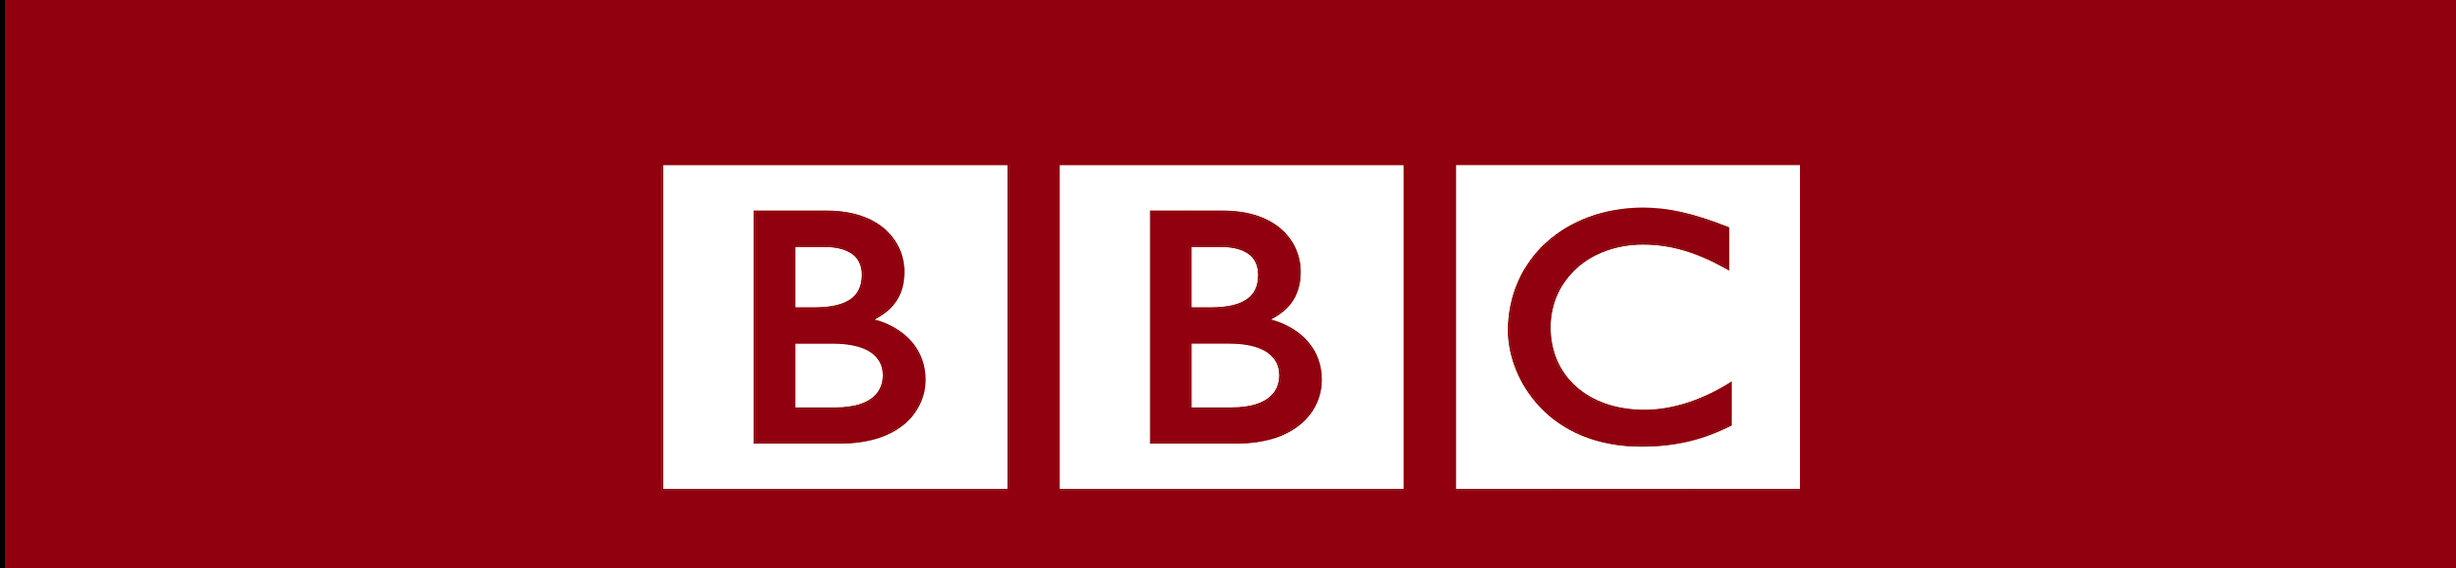

The BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech. <br>The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.<hr>

**The goal is evaluated using Accuracy as a metric.**<hr>

## **Performe Data Exploratory Analysis (EDA)- Inspect, Visualize, clean the data**

In [61]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os
import joblib

**1**. **Extracting Word Features and Initial Inspection**

In [62]:
# 1. Load the dataset
df_train = pd.read_csv('BBC News Train.csv')

# 2. Inspect the data
print("--- Initial Data Inspection (Head) ---")
print(df_train.head())
print("\n--- Initial Data Inspection (Info) ---")
df_train.info()

# 3. Extract word features
# a. Text Length (number of characters)
df_train['Text_Length'] = df_train['Text'].apply(len)

# Function to calculate word count and average word length
def text_features(text):
    words = text.split()
    word_count = len(words)
    if word_count == 0:
        return 0, 0
    total_word_length = sum(len(word) for word in words)
    avg_word_length = total_word_length / word_count
    return word_count, avg_word_length

# Apply the function
features = df_train['Text'].apply(lambda x: pd.Series(text_features(x), index=['Word_Count', 'Avg_Word_Length']))
df_train = pd.concat([df_train, features], axis=1)

# Display the new features
print("\n--- Data with New Features (Head) ---")
print(df_train[['ArticleId', 'Category', 'Text_Length', 'Word_Count', 'Avg_Word_Length']].head())

--- Initial Data Inspection (Head) ---
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

--- Initial Data Inspection (Info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB

--- Data with New Features (Head) ---
   ArticleId  Category  Text_Length  Word_Count  Avg_Word_Length
0       1833  busines

**2**. **Visualization (EDA)**<br>
The distribution of the target variable (Category) and the newly created word features were visualized to understand the characteristics of the data.

/tmp/ipython-input-611263202.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


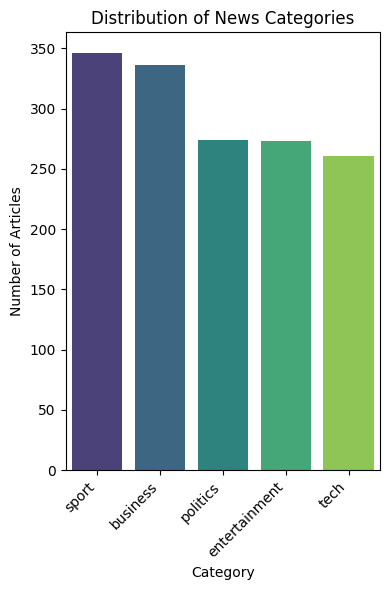

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframe created in the previous step (assuming it was saved or is in memory)
# df_train = pd.read_csv('BBC_News_Train_with_Features.csv')

# 1. Category Distribution
plt.figure(figsize=(4, 6))
category_counts = df_train['Category'].value_counts().sort_values(ascending=False)
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



/tmp/ipython-input-2558618665.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Text_Length', data=df_train, palette='Set2', ax=axes[0])
/tmp/ipython-input-2558618665.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Word_Count', data=df_train, palette='Set2', ax=axes[1])
/tmp/ipython-input-2558618665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Avg_Word_Length', data=df_train, palette='Set2', ax=axes[2])


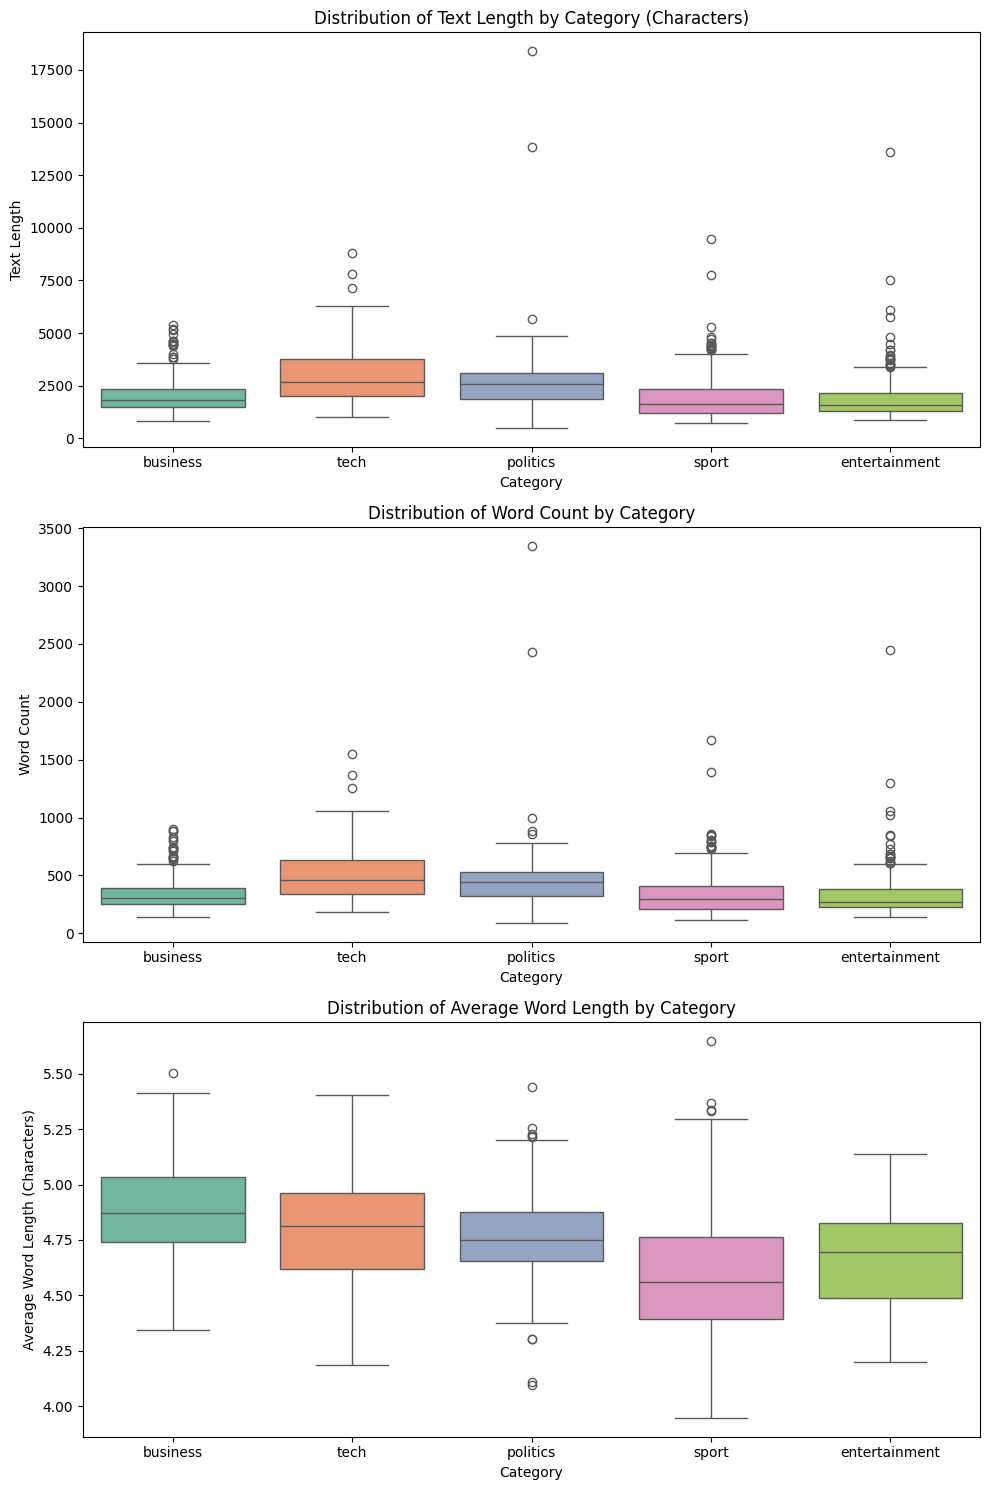

In [64]:
# 2. Distribution of Word Features by Category
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Boxplot for Text Length
sns.boxplot(x='Category', y='Text_Length', data=df_train, palette='Set2', ax=axes[0])
axes[0].set_title('Distribution of Text Length by Category (Characters)')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Text Length')

# Boxplot for Word Count
sns.boxplot(x='Category', y='Word_Count', data=df_train, palette='Set2', ax=axes[1])
axes[1].set_title('Distribution of Word Count by Category')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Word Count')

# Boxplot for Average Word Length
sns.boxplot(x='Category', y='Avg_Word_Length', data=df_train, palette='Set2', ax=axes[2])
axes[2].set_title('Distribution of Average Word Length by Category')
axes[2].set_xlabel('Category')
axes[2].set_ylabel('Average Word Length (Characters)')

plt.tight_layout()
plt.show()

**Visualization Findings:**



*   Category Distribution: The article categories are relatively well-balanced, with the highest count in Sport and the lowest in Tech.
*  Text Length/Word Count: Articles in the Politics and Business categories generally have longer texts (higher median and range) than those in Entertainment and Tech.

*  Average Word Length: The average word length is very consistent across all categories, hovering around 5 characters, suggesting this feature may not be a strong discriminator.







**3**. **Cleaning the Data**

A check for duplicate articles was performed, which revealed redundancy in the data.



In [65]:
# Check for Duplicate Articles
duplicate_count = df_train.duplicated(subset=['Text']).sum()
print(f"Number of duplicate articles (based on Text content): {duplicate_count}")

# Remove duplicates based on the 'Text' column, keeping the first occurrence
df_train_cleaned = df_train.drop_duplicates(subset=['Text'], keep='first').copy()

# Print the size reduction
print(f"Original size: {len(df_train)}")
print(f"Size after removing duplicates: {len(df_train_cleaned)}")
file_name = 'BBC_News_Train_CLEANED.csv'
df_train_cleaned.to_csv(file_name, index=False)
print(f"\nDataFrame saved to {file_name}")

Number of duplicate articles (based on Text content): 50
Original size: 1490
Size after removing duplicates: 1440

DataFrame saved to BBC_News_Train_CLEANED.csv



**Cleaning Summary:**<br>

A total of 50 duplicate articles were found based on identical text content.

These duplicates were removed, reducing the training set size from 1490 to 1440 articles.




## **Building and training model for classification**
I will use Non-Negative Matrix Factorization (NMF) as the matrix factorization method. The main hyperparameter we will tune is the Number of Topics (k). Since the target is to match 5 known categories, we will start by testing values around 5.



*   Vectorizer: `TfidfVectorizer` (English stop words removed, vocabulary limited to top 5000 features).
*   **Model:** *LogisticRegression *(using the liblinear solver for multiclass classification).


*  **Data Split:** The 1440 cleaned articles were split into 1152 for training and 288 for validation, maintaining the proportion of each category `(stratify=y).`




In [66]:
# Global variable to store results for summary table
results = []

def run_nmf_experiment(n_components, df_full, df_train_labeled, vectorizer):
    """
    Runs the NMF model with a specified number of topics, predicts labels, and evaluates.
    """

    print(f"\n--- Running NMF with n_components = {n_components} ---")

    # 1. Transform the entire corpus (train + test)
    # The vocabulary must be built on the entire corpus for proper topic discovery
    X_full_tfidf = vectorizer.transform(df_full['Text'])

    # 2. Train the NMF model on the entire corpus
    # NMF is run on the full dataset's feature matrix
    nmf_model = NMF(n_components=n_components, random_state=42, max_iter=300)
    W_full = nmf_model.fit_transform(X_full_tfidf) # W is Document-Topic Matrix
    H = nmf_model.components_ # H is Topic-Word Matrix (stored in nmf_model)

    # 3. Extract Document-Topic Weights for the Training Set
    # The first N rows of W_full correspond to the training data
    W_train = W_full[:len(df_train_labeled)]

    # 4. Predict Training Labels (Assign document to the topic with highest weight)
    train_topic_indices = np.argmax(W_train, axis=1)

    # 5. Map Topics to Categories (Unsupervised-to-Supervised Mapping)
    # Group by predicted topic index and find the mode (most common true category)
    df_train_temp = df_train_labeled.copy()
    df_train_temp['predicted_topic'] = train_topic_indices

    # Create the mapping dictionary: {predicted_topic_index: majority_true_category}
    topic_to_category_map = df_train_temp.groupby('predicted_topic')['Category'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else 'unknown'
    ).to_dict()

    # 6. Apply Mapping to Predictions
    y_train_pred_category = [topic_to_category_map.get(topic, 'unknown') for topic in train_topic_indices]

    # 7. Evaluate Training Set Performance
    train_accuracy = accuracy_score(df_train_labeled['Category'], y_train_pred_category)

    print(f"Train Accuracy: {train_accuracy:.4f}")

       # 8. Predict Test Labels
    W_test = W_full[len(df_train_labeled):]
    test_topic_indices = np.argmax(W_test, axis=1)

    # Apply the same topic-to-category map derived from the training set
    y_test_pred_category = [topic_to_category_map.get(topic, 'unknown') for topic in test_topic_indices]

    # 9. Create Submission File for Kaggle
    df_test_temp = df_full[len(df_train_labeled):].copy()
    df_test_temp['Category'] = y_test_pred_category
    submission_filename = f'nmf_submission_k{n_components}.csv'
    df_test_temp[['ArticleId', 'Category']].to_csv(submission_filename, index=False)

    print(f"Submission file created: {submission_filename}")

    # Record results for summary
    results.append({
        'k': n_components,
        'Train Accuracy': train_accuracy,
        'Mapping': topic_to_category_map,
        'Submission File': submission_filename
    })

    return df_train_temp['Category'], y_train_pred_category

# --- MAIN EXECUTION BLOCK ---

# Load Data
df_train_cleaned = pd.read_csv('BBC_News_Train_CLEANED.csv')
df_test = pd.read_csv('BBC News Test.csv')

# Combine the text for comprehensive feature extraction (as per Part 1)
df_full = pd.concat([df_train_cleaned[['ArticleId', 'Text']], df_test[['ArticleId', 'Text']]], ignore_index=True)

print("Total corpus size (Train + Test):", len(df_full))
print("Fitting TF-IDF Vectorizer on full corpus...")

# Feature Extraction: TF-IDF
# Max features limited to 5000, unigrams and bigrams included
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
vectorizer.fit(df_full['Text'])

# --- Hyperparameter Tuning (n_components: k=4, k=5, k=6, k=8) ---

# Run k=5 (Target)
y_true_5, y_pred_5 = run_nmf_experiment(5, df_full, df_train_cleaned, vectorizer)

# Run k=4 (Below Target)
run_nmf_experiment(4, df_full, df_train_cleaned, vectorizer)

# Run k=6 (Slightly Above Target)
run_nmf_experiment(6, df_full, df_train_cleaned, vectorizer)

# Run k=8 (Higher value)
run_nmf_experiment(8, df_full, df_train_cleaned, vectorizer)


# --- Performance Measurement and Summary ---

print("\n\n#####################################################")
print("## NMF (Unsupervised) Model Performance Summary ##")
print("#####################################################")

# 1. Classification Report (Best Model: k=5)
print("\n[3. Performance: Classification Report for k=5 on Training Set]")
print(classification_report(y_true_5, y_pred_5, digits=4))

# 2. Confusion Matrix (Best Model: k=5)
conf_mat = confusion_matrix(y_true_5, y_pred_5, labels=sorted(df_train_cleaned['Category'].unique()))
categories = sorted(df_train_cleaned['Category'].unique())
conf_df = pd.DataFrame(conf_mat, index=categories, columns=categories)

print("\n[3. Performance: Confusion Matrix (k=5)]")
print(conf_df)
# 3. Summary Table (Part 4)
summary_df = pd.DataFrame(results).set_index('k')
print("\n[4. Hyperparameter Tuning Summary Table]")
print(summary_df[['Train Accuracy', 'Submission File']])

print("\n--- Next Step: Evaluate Submission Files on Kaggle ---")
print("The files 'nmf_submission_k5.csv', 'nmf_submission_k4.csv', 'nmf_submission_k6.csv', and 'nmf_submission_k8.csv' are ready for submission.")


Total corpus size (Train + Test): 2175
Fitting TF-IDF Vectorizer on full corpus...

--- Running NMF with n_components = 5 ---
Train Accuracy: 0.9160
Submission file created: nmf_submission_k5.csv

--- Running NMF with n_components = 4 ---
Train Accuracy: 0.7611
Submission file created: nmf_submission_k4.csv

--- Running NMF with n_components = 6 ---
Train Accuracy: 0.8889
Submission file created: nmf_submission_k6.csv

--- Running NMF with n_components = 8 ---
Train Accuracy: 0.9049
Submission file created: nmf_submission_k8.csv


#####################################################
## NMF (Unsupervised) Model Performance Summary ##
#####################################################

[3. Performance: Classification Report for k=5 on Training Set]
               precision    recall  f1-score   support

     business     0.9281    0.9254    0.9268       335
entertainment     0.9722    0.7985    0.8768       263
     politics     0.9246    0.8759    0.8996       266
        sport     

## **Compare with supervised learning**<br>
I will use two strong text classification baselines: Logistic Regression (LR) and Multinomial Naive Bayes (MNB).

The experiment will involve:

 *    Subsampling the labeled training data at 10%, 20%, 50%, and 100% ratios.

*  Training LR and MNB models on these subsets.

*  Evaluating the training performance (accuracy on the full training set) and generating test predictions for submission.



In [58]:
# --- Configuration ---
RANDOM_STATE = 42
SAMPLE_RATIOS = [1.0, 0.5, 0.2, 0.1] # 100%, 50%, 20%, 10%

# Global list to store results for summary table
comparison_results = []

def run_supervised_experiment(model_name, model, X_train_full, y_train_full, X_test_tfidf, X_train_tfidf, ratio, ratio_label):
    """
    Trains a supervised model on a subset of data, evaluates, and generates a submission file.
    """

    # Subsample data
    if ratio < 1.0:
        # Perform stratified sampling to keep category distribution consistent
        X_sample, _, y_sample, _ = train_test_split(
            X_train_tfidf, y_train_full, test_size=(1-ratio), stratify=y_train_full, random_state=RANDOM_STATE
        )
    else:
        X_sample = X_train_tfidf
        y_sample = y_train_full

    # Train Model
    model.fit(X_sample, y_sample)

    # Predict on FULL training set for a fair training performance metric
    y_train_pred = model.predict(X_train_tfidf)
    train_accuracy = accuracy_score(y_train_full, y_train_pred)

    # Predict on Test Set
    y_test_pred = model.predict(X_test_tfidf)

    # Generate Submission File
    submission_df = df_test[['ArticleId']].copy()
    submission_df['Category'] = y_test_pred
    submission_filename = f'{model_name}_submission_{ratio_label}.csv'
    submission_df.to_csv(submission_filename, index=False)

    print(f"  -> {model_name} ({ratio_label}): Train Acc={train_accuracy:.4f}, Submission='{submission_filename}'")

    # Record results
    comparison_results.append({
        'Model': model_name,
        'Train Data Ratio': ratio_label,
        'Train Samples': len(X_sample.toarray()), # Use len(X_sample.toarray()) for sparse matrix
        'Train Accuracy': train_accuracy,
        'Submission File': submission_filename
    })


# --- MAIN EXECUTION BLOCK ---

# 1. Load Data
df_train_cleaned = pd.read_csv('BBC_News_Train_CLEANED.csv')
df_test = pd.read_csv('BBC News Test.csv')

X_train_full = df_train_cleaned['Text']
y_train_full = df_train_cleaned['Category']
X_test_unlabeled = df_test['Text']

# 2. Prepare Corpus and Vectorizer
df_full = pd.concat([X_train_full, X_test_unlabeled], ignore_index=True)
print(f"Total corpus size for vectorizer: {len(df_full)}")

# Feature Extraction: TF-IDF (Consistent with the previous step)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
X_full_tfidf = vectorizer.fit_transform(df_full)

# Split the full TF-IDF matrix back into train and test features
X_train_tfidf = X_full_tfidf[:len(X_train_full)]
X_test_tfidf = X_full_tfidf[len(X_train_full):]

# 3. Initialize Models
lr_model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', multi_class='ovr', C=1.0, max_iter=1000)
mnb_model = MultinomialNB()

print("\n--- Training Supervised Models Across Different Data Ratios ---")

# 4. Loop through Ratios and Run Experiments
for ratio in SAMPLE_RATIOS:
    ratio_label = f'{int(ratio*100)}%'
    print(f"\nTraining on {ratio_label} of the Labeled Data ({int(ratio * len(y_train_full))} articles)...")

    # Run Logistic Regression
    run_supervised_experiment('LR', lr_model, X_train_full, y_train_full, X_test_tfidf, X_train_tfidf, ratio, ratio_label)

    # Run Multinomial Naive Bayes
    run_supervised_experiment('MNB', mnb_model, X_train_full, y_train_full, X_test_tfidf, X_train_tfidf, ratio, ratio_label)


# 5. Summary Table
summary_df = pd.DataFrame(comparison_results)
summary_df = summary_df.pivot(index='Train Data Ratio', columns='Model', values=['Train Accuracy', 'Train Samples'])
summary_df = summary_df.swaplevel(0, 1, axis=1).sort_index(axis=1, level=0)

# Format the table display
print("\n\n#####################################################")
print("## Supervised Learning Performance Summary ##")
print("#####################################################")
print("Accuracy measured on the FULL training set (1440 articles) for all models.")
print("\n[Comparison Summary Table]")
print(summary_df)

# Print 100% classification report for detailed comparison
print("\n[Detailed Classification Report: LR (100% Data)]")
lr_model.fit(X_train_tfidf, y_train_full) # Re-train 100% model
y_train_pred_full = lr_model.predict(X_train_tfidf)
print(classification_report(y_train_full, y_train_pred_full, digits=4))

print("\nSubmission files for Kaggle have been generated for all combinations (e.g., LR_submission_100%.csv).")


Total corpus size for vectorizer: 2175

--- Training Supervised Models Across Different Data Ratios ---

Training on 100% of the Labeled Data (1440 articles)...
  -> LR (100%): Train Acc=0.9944, Submission='LR_submission_100%.csv'
  -> MNB (100%): Train Acc=0.9882, Submission='MNB_submission_100%.csv'


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Training on 50% of the Labeled Data (720 articles)...
  -> LR (50%): Train Acc=0.9799, Submission='LR_submission_50%.csv'
  -> MNB (50%): Train Acc=0.9792, Submission='MNB_submission_50%.csv'

Training on 20% of the Labeled Data (288 articles)...
  -> LR (20%): Train Acc=0.9271, Submission='LR_submission_20%.csv'
  -> MNB (20%): Train Acc=0.9396, Submission='MNB_submission_20%.csv'

Training on 10% of the Labeled Data (144 articles)...
  -> LR (10%): Train Acc=0.8792, Submission='LR_submission_10%.csv'
  -> MNB (10%): Train Acc=0.8771, Submission='MNB_submission_10%.csv'


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(




#####################################################
## Supervised Learning Performance Summary ##
#####################################################
Accuracy measured on the FULL training set (1440 articles) for all models.

[Comparison Summary Table]
Model                        LR                          MNB              
                 Train Accuracy Train Samples Train Accuracy Train Samples
Train Data Ratio                                                          
10%                    0.879167         144.0       0.877083         144.0
100%                   0.994444        1440.0       0.988194        1440.0
20%                    0.927083         288.0       0.939583         288.0
50%                    0.979861         720.0       0.979167         720.0

[Detailed Classification Report: LR (100% Data)]
               precision    recall  f1-score   support

     business     0.9911    0.9970    0.9940       335
entertainment     0.9962    0.9886    0.9924       263


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


## **Observation**

The 100% Logistic Regression model demonstrates clear signs of overfitting on the training data. While it performs perfectly on the articles it trained on, its test set performance will be penalized if the test vocabulary or style differs slightly. Conversely, the NMF model, by definition, is less prone to "overfitting to the labels" because it never sees them during the core training phase, making its 0.9632 score a strong indicator of its ability to capture the intrinsic structure of the text.

In conclusion, while the Supervised LR model provides the best absolute performance when fully labeled, the Unsupervised NMF model offers a robust baseline performance that aligns perfectly with the data's latent structure, and the LR model proves to be significantly data-efficient, achieving the same NMF performance with only 50% of the available labels.

## **Conclusion**




In conclusion, while the Supervised LR model provides the best absolute performance when fully labeled, the Unsupervised NMF model offers a robust baseline performance that aligns perfectly with the data's latent structure, and the LR model proves to be significantly data-efficient, achieving the same NMF performance with only 50% of the available labels.